In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 
from scipy import stats

In [3]:
zri_acs_bs = pd.read_csv('../data/zri_acs_bikeshare_merged.csv')
zri_acs_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93672 entries, 0 to 93671
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   zip                               93672 non-null  int64  
 1   City                              93672 non-null  object 
 2   State                             93672 non-null  object 
 3   Metro                             93672 non-null  object 
 4   CountyName                        93672 non-null  object 
 5   zri                               93672 non-null  float64
 6   year                              93672 non-null  int64  
 7   month                             93672 non-null  int64  
 8   datetime                          93672 non-null  object 
 9   percent_white                     93672 non-null  float64
 10  percent_black                     93672 non-null  float64
 11  percent_asian                     93672 non-null  float64
 12  perc

In [12]:
temp = zri_acs_bs[zri_acs_bs['year']==2018]

<AxesSubplot:>

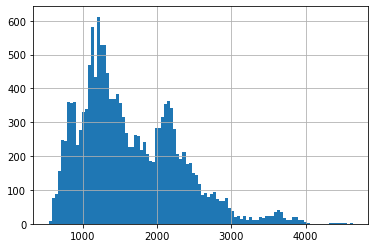

In [14]:
temp['zri'].hist(bins=100)

<AxesSubplot:>

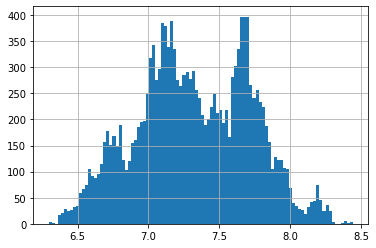

In [15]:
np.log(temp['zri']).hist(bins=100)

In [10]:
zri_acs_bs['zip'] = zri_acs_bs['zip'].astype('string')
zri_acs_bs['zip'] = ["0"+z if len(z)<5 else z for z in zri_acs_bs['zip']]

In [11]:
zri_acs_bs

,zip,City,State,Metro,CountyName,zri,year,month,datetime,percent_white,...,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen,bs_total_stations,bs_total_systems,has_bike_sharing
0,01013,Chicopee,MA,Springfield,Hampden County,928.0,2014,1,2014-01-01,0.728315,...,22343.583333,0.104130,0.009346,36.416667,0.509533,0.420742,0.056062,0.0,0.0,0
1,01013,Chicopee,MA,Springfield,Hampden County,931.0,2014,2,2014-02-01,0.727052,...,22296.166667,0.104147,0.009839,36.433333,0.508816,0.420483,0.056165,0.0,0.0,0
2,01013,Chicopee,MA,Springfield,Hampden County,934.0,2014,3,2014-03-01,0.725788,...,22248.750000,0.104165,0.010332,36.450000,0.508100,0.420225,0.056267,0.0,0.0,0
3,01013,Chicopee,MA,Springfield,Hampden County,929.0,2014,4,2014-04-01,0.724525,...,22201.333333,0.104182,0.010825,36.466667,0.507383,0.419967,0.056370,0.0,0.0,0
4,01013,Chicopee,MA,Springfield,Hampden County,929.0,2014,5,2014-05-01,0.723261,...,22153.916667,0.104199,0.011318,36.483333,0.506666,0.419708,0.056472,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93667,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,1277.0,2019,8,2019-08-01,0.796036,...,60057.000000,0.102326,0.049199,33.566667,0.475244,0.399400,0.018076,0.0,0.0,0
93668,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,1271.0,2019,9,2019-09-01,0.795709,...,60203.000000,0.102254,0.049419,33.575000,0.475511,0.399650,0.018306,0.0,0.0,0
93669,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,1299.0,2019,10,2019-10-01,0.795381,...,60349.000000,0.102181,0.049640,33.583333,0.475778,0.399900,0.018537,0.0,0.0,0
93670,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,1261.5,2019,11,2019-11-01,0.795054,...,60495.000000,0.102109,0.049861,33.591667,0.476045,0.400150,0.018767,0.0,0.0,0


In [12]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

# 1. LASSO only on Autoregressive (Rent index) 

In [13]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")
zri = zri.drop(index=zri[zri['zip']=="11249"].index)

In [14]:
zri_lags = zri.copy()
for i in range(1,4):
    zri_lags =laggenerator(i, 'zri',zri_lags)


In [15]:
zri_lags

,zip,City,State,Metro,CountyName,year-month,zri,year,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,928.0,2014,0.0,0.0,0.0
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,931.0,2014,928.0,0.0,0.0
2,01013,Chicopee,MA,Springfield,Hampden County,2014-03-01,934.0,2014,931.0,928.0,0.0
3,01013,Chicopee,MA,Springfield,Hampden County,2014-04-01,929.0,2014,934.0,931.0,928.0
4,01013,Chicopee,MA,Springfield,Hampden County,2014-05-01,929.0,2014,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-08-01,1277.0,2019,1291.0,1294.0,1296.0
93740,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-09-01,1271.0,2019,1277.0,1291.0,1294.0
93741,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-10-01,1299.0,2019,1271.0,1277.0,1291.0
93742,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-11-01,1261.5,2019,1299.0,1271.0,1277.0


In [16]:
train = zri_lags[zri_lags['year'] < 2019]
test = zri_lags[zri_lags['year']==2019]
train = train.drop(['year'],axis=1)
test = test.drop(['year'],axis=1)

In [17]:
train_y = train['zri']
train_X = train.drop(['zri'],axis=1)

test_y = test['zri']
test_X = test.drop(['zri'],axis=1)

In [18]:
train_X

,zip,City,State,Metro,CountyName,year-month,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,0.0,0.0,0.0
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,928.0,0.0,0.0
2,01013,Chicopee,MA,Springfield,Hampden County,2014-03-01,931.0,928.0,0.0
3,01013,Chicopee,MA,Springfield,Hampden County,2014-04-01,934.0,931.0,928.0
4,01013,Chicopee,MA,Springfield,Hampden County,2014-05-01,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...
93727,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-08-01,1332.0,1334.0,1335.0
93728,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-09-01,1337.0,1332.0,1334.0
93729,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-10-01,1337.0,1337.0,1332.0
93730,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-11-01,1335.0,1337.0,1337.0


# Just zri_lag1, zri_lag2, zri_lag3 (no city, state, metro, county, year-month encoding) 

In [19]:
cols = ['zip','zri_lag1','zri_lag2','zri_lag3']
train_X_1 = train_X[cols]
test_X_1 = test_X[['zip','zri_lag1','zri_lag2','zri_lag3']]

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [21]:
#1. Label encode zip
le = LabelEncoder()
train_X_1.loc[:,'zip'] = le.fit_transform(train_X_1.loc[:,'zip'])
test_X_1.loc[:,'zip'] = le.transform(test_X_1.loc[:,'zip'])

/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [80]:
#2. Standard Scaler to all data 
scaler = StandardScaler()
train_X_1_scaled = scaler.fit_transform(train_X_1)
test_X_1_scaled = scaler.transform(test_X_1)

In [81]:
#3. Lasso Grid Search
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_1_scaled,train_y)
lasso_best = lasso_grid.best_estimator_

In [96]:
print(f'lasso_best : {lasso_best}')
lasso_best.fit(train_X_1_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_1_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_1_scaled),test_y))}')


lasso_best : Lasso(alpha=10)
LASSO
R2: 0.9907254530402929
RMSE: 64.07234255283224


In [102]:
importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(cols)
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
#feature_importances[feature_importances['coef_abs']>0]
feature_importances

,feature_names,coef_abs,coef
1,zri_lag1,618.524547,618.524547
3,zri_lag3,1.680364,1.680364
0,zip,0.0,-0.0
2,zri_lag2,0.0,0.0


# zri_lag1, zri_lag2, zri_lag3 and encoding for city, state, metro, county

In [22]:
cols = ['zip', 'City', 'State', 'Metro', 'CountyName','zri_lag1','zri_lag2', 'zri_lag3']
train_X_2 = train_X[cols]
test_X_2 = test_X[cols]

In [23]:
#1. Label encode zip, city, state, metro, countyname, year-month 
le1 = LabelEncoder()
train_X_2.loc[:,'zip'] = le1.fit_transform(train_X_2.loc[:,'zip'])
test_X_2.loc[:,'zip'] = le1.transform(test_X_2.loc[:,'zip'])

le2 = LabelEncoder()
train_X_2.loc[:,'City'] = le2.fit_transform(train_X_2.loc[:,'City'])
test_X_2.loc[:,'City'] = le2.transform(test_X_2.loc[:,'City'])

le3 = LabelEncoder()
train_X_2.loc[:,'State'] = le3.fit_transform(train_X_2.loc[:,'State'])
test_X_2.loc[:,'State'] = le3.transform(test_X_2.loc[:,'State'])

le4 = LabelEncoder()
train_X_2.loc[:,'Metro'] = le4.fit_transform(train_X_2.loc[:,'Metro'])
test_X_2.loc[:,'Metro'] = le4.transform(test_X_2.loc[:,'Metro'])

le5 = LabelEncoder()
train_X_2.loc[:,'CountyName'] = le5.fit_transform(train_X_2.loc[:,'CountyName'])
test_X_2.loc[:,'CountyName'] = le5.transform(test_X_2.loc[:,'CountyName'])

In [24]:
#2. Standard Scaler to all data 
scaler = StandardScaler()
train_X_2_scaled = scaler.fit_transform(train_X_2)
test_X_2_scaled = scaler.transform(test_X_2)

In [119]:
#3. Lasso Grid Search
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_2_scaled,train_y)
lasso_best = lasso_grid.best_estimator_

In [120]:
print(f'lasso_best : {lasso_best}')
lasso_best.fit(train_X_2_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_2_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_2_scaled),test_y))}')


lasso_best : Lasso(alpha=10)
LASSO
R2: 0.9907032952782536
RMSE: 64.14883430969256


In [121]:
importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(cols)
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
#feature_importances[feature_importances['coef_abs']>0]
feature_importances

,feature_names,coef_abs,coef
5,zri_lag1,615.625118,615.625118
2,State,7.433775,-7.433775
4,CountyName,3.568662,3.568662
7,zri_lag3,2.273785,2.273785
0,zip,0.0,-0.0
1,City,0.0,0.0
3,Metro,0.0,0.0
6,zri_lag2,0.0,0.0


# Add in bike features

In [65]:
zri_acs_bs["datetime"] = pd.to_datetime(zri_acs_bs["datetime"],format="%Y-%m")

KeyError: 'datetime'

In [66]:
zri_acs_bs = zri_acs_bs.rename(columns={"datetime": "year-month"})

In [67]:
zri_acs_bs_lags = zri_acs_bs.copy()
zri_acs_bs_lags.rename(columns={"datetime": "year-month"})
for i in range(1,4):
    zri_acs_bs_lags =laggenerator(i, 'zri',zri_acs_bs_lags)

In [68]:
for i in range(1,4):
    zri_acs_bs_lags =laggenerator(i, 'bs_total_stations',zri_acs_bs_lags)
for i in range(1,4):
    zri_acs_bs_lags =laggenerator(i, 'bs_total_systems',zri_acs_bs_lags)
for i in range(1,4):
    zri_acs_bs_lags =laggenerator(i, 'has_bike_sharing',zri_acs_bs_lags)

In [69]:
zri_acs_bs_lags.columns

Index(['zip', 'City', 'State', 'Metro', 'CountyName', 'zri', 'year', 'month',
       'year-month', 'percent_white', 'percent_black', 'percent_asian',
       'percent_hispanic', 'percent_native_am', 'percent_other_race',
       'percent_0_17', 'percent_18_39', 'percent_40_64', 'percent_65+',
       'percent_rental_units_vacant', 'percent_rental_units_occupied',
       'percent_graduate_deg', 'percent_bachelors', 'percent_associates',
       'percent_highschool', 'percent_less_highschool',
       'percent_commute_public_transport', 'percent_commute_less_30',
       'percent_buildings_less_10_units', 'percent_buildings_10_19_units',
       'percent_buildings_20_49_units', 'percent_buildings_50+_units',
       'percent_commute_30_to_59', 'percent_commute_60_to_89',
       'percent_commute_90_more', 'percent_new_city', 'percent_new_unit',
       'percent_units_owner_occupied', 'median_building_age',
       'income_per_capita', 'poverty_rate', 'total_pop',
       'percent_workforce_unemploye

In [70]:
remove_cols = ['zip','City','Metro','month',
       'year-month', 'percent_white', 'percent_black', 'percent_asian',
       'percent_hispanic', 'percent_native_am', 'percent_other_race',
       'percent_0_17', 'percent_18_39', 'percent_40_64', 'percent_65+',
       'percent_rental_units_vacant', 'percent_rental_units_occupied',
       'percent_graduate_deg', 'percent_bachelors', 'percent_associates',
       'percent_highschool', 'percent_less_highschool',
       'percent_commute_public_transport', 'percent_commute_less_30',
       'percent_buildings_less_10_units', 'percent_buildings_10_19_units',
       'percent_buildings_20_49_units', 'percent_buildings_50+_units',
       'percent_commute_30_to_59', 'percent_commute_60_to_89',
       'percent_commute_90_more', 'percent_new_city', 'percent_new_unit',
       'percent_units_owner_occupied', 'median_building_age',
       'income_per_capita', 'poverty_rate', 'total_pop',
       'percent_workforce_unemployed', 'percent_work_from_home', 'median_age',
       'percent_female', 'gini_index', 'percent_not_us_citizen']

In [71]:
zri_bikes = zri_acs_bs_lags.drop(remove_cols,axis=1)

In [75]:
del train, test, train_X,train_y,test_X,test_y

In [76]:
train = zri_bikes[zri_bikes['year'] < 2019]
test = zri_bikes[zri_bikes['year']==2019]
train = train.drop(['year'],axis=1)
test = test.drop(['year'],axis=1)

train_y = train['zri']
train_X = train.drop(['zri'],axis=1)

test_y = test['zri']
test_X = test.drop(['zri'],axis=1)

In [79]:
#1. Label encode state & countyname 
le1 = LabelEncoder()
train_X.loc[:,'State'] = le1.fit_transform(train_X.loc[:,'State'])
test_X.loc[:,'State'] = le1.transform(test_X.loc[:,'State'])


le2 = LabelEncoder()
train_X.loc[:,'CountyName'] = le2.fit_transform(train_X.loc[:,'CountyName'])
test_X.loc[:,'CountyName'] = le2.transform(test_X.loc[:,'CountyName'])

In [80]:
#2. Standard Scaler to all data 
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [81]:
#3. Lasso Grid Search
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_scaled,train_y)
lasso_best = lasso_grid.best_estimator_

In [85]:
print(f'lasso_best : {lasso_best}')
lasso_best.fit(train_X_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_scaled),test_y))}')


lasso_best : Lasso(alpha=1)
LASSO
R2: 0.9923956491279403
RMSE: 58.017007464770344


In [89]:
importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(train_X.columns)
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
#feature_importances[feature_importances['coef_abs']>0]
feature_importances

,feature_names,coef_abs,coef
5,zri_lag1,616.307255,616.307255
0,State,15.556929,-15.556929
1,CountyName,11.972741,11.972741
7,zri_lag3,6.961956,6.961956
8,bs_total_stations_lag1,1.958252,1.958252
12,bs_total_systems_lag2,0.471808,0.471808
11,bs_total_systems_lag1,0.278298,0.278298
9,bs_total_stations_lag2,0.23195,0.23195
13,bs_total_systems_lag3,0.147901,0.147901
16,has_bike_sharing_lag3,0.145626,0.145626


In [ ]:
#lasso with just bike share has rmse 58.017, down from 64.148 on just the rent index

In [ ]:
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_scaled,train_y)
lasso_best = lasso_grid.best_estimator_
lasso_best.fit(train_X_scaled, train_y)
lasso_best.fit(train_X_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_scaled),test_y))}')

importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(train_X.columns.to_list())
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
feature_importances[feature_importances['coef_abs']>0]

sfm = SelectFromModel(lasso).fit(train_X_scaled, train_y)
print("Features selected by SelectFromModel: \n"
      f"{feature_names[sfm.get_support()]}")

# Add lagged columns
- ZRI lags: last 3 months
- ACS lags: 12 months before, 24 months before

In [16]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

In [ ]:
# zri_acs_bs_lags = zri_acs_bs.copy()
# for i in range(1,4):
#     zillow_lags=laggenerator(i, 'zri',zri_acs_bs_lags)